In [1]:
pwd

'/home/vmu/nu_stats'

In [2]:
%cd examples/bayes_hierarchical_model/

/home/vmu/nu_stats/examples/bayes_hierarchical_model


In [3]:
%load_ext autoreload
%autoreload 2

# SIM

In [4]:
from astropy import units as u
import numpy as np
from matplotlib import pyplot as plt
import corner

In [5]:
import sys
sys.path.append("../../")
from nu_stats.simulation import Simulation
from nu_stats.plotting import unit_vectors_skymap as u_v_s

In [6]:
# Simulation parameters
L = 1e48 * (u.erg/u.s)
gamma = 2.2
z = 0.3
F_diff_norm = 1e-15 * 1/(u.GeV * u.cm**2 * u.s)
Emin = 1e5 * u.GeV
Emax = 1e8 * u.GeV
Enorm = 1e5 * u.GeV

In [7]:
sim = Simulation(L, gamma, z, F_diff_norm, Emin=Emin, Emax=Emax, Enorm=Enorm)
sim.run(seed=4, verbose=True)


Simulated 288 events


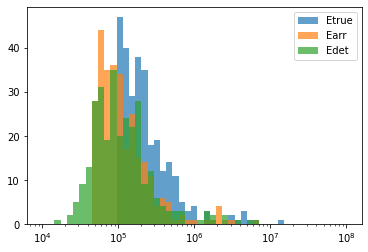

In [8]:
sim.show_spectrum()

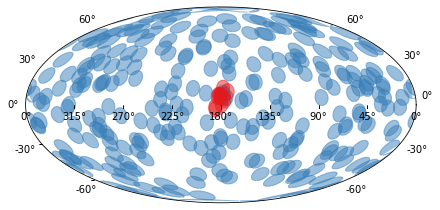

In [9]:
sim.show_skymap()

In [10]:
# Extract simulated data and get info needed for fit
fit_input = sim.get_data()

## Truths

In [12]:
sim.truth

OrderedDict([('L', 6.2415090744607645e+50),
             ('gamma', 2.2),
             ('F_bg', 8.331240094640407e-07),
             ('f', 0.05463271416561316)])

In [13]:
# How many simulated source events
sum(sim.labels==0)

14

In [14]:
# How many expected simulated source events
sim.Nex_ps

15.193779688702278

# FQ FIT

In [15]:
from nu_stats.fqutils import FqStructure, plot_loghist

In [16]:
fq = FqStructure()
fq.construct_diffuse_bg_energy_likelihood(
    fit_input['z_bg'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/False1.0_25lik.npy'
    )
fq.construct_source_energy_likelihood(
    fit_input['z'], Emin, Emax, min_index=1.5, max_index=4.0, n_Esim=100000,
    Nbins=25, prefab_likelihood_file='tmp/True0.3_25lik.npy'
)

Generating marginalized background energy likelihood..
Separate marginalized energy likelihood generated for bg.
Generating marginalized energy likelihood..
Marginalized energy likelihood generated.


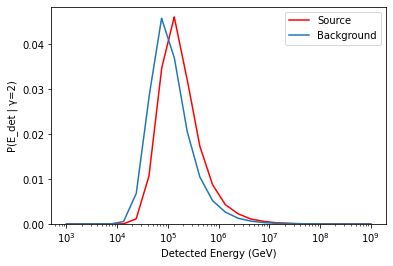

In [17]:
fig, ax = plt.subplots()

fq.energy_likelihood.plot_pdf_at_idx(2.2, color = 'r', label='Source')

fq.bg_energy_likelihood.plot_pdf_at_idx(2.2, label='Background')

ax.set_xlabel('Detected Energy (GeV)')
ax.set_ylabel(f'P(E_det | γ=2)')
ax.set_ylim(0,(ax.get_ylim()[1]))
ax.legend()
plt.show()

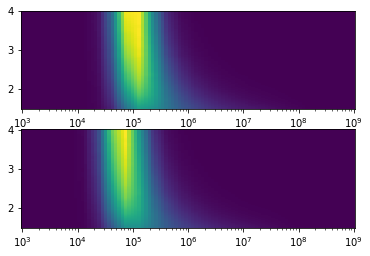

In [18]:
fig, ax = plt.subplots(2,1)
plt.sca(ax[0])
fq.energy_likelihood.plot_pdf_meshgrid()
plt.sca(ax[1])
fq.bg_energy_likelihood.plot_pdf_meshgrid()

In [19]:
fq.fit_input = fit_input

In [20]:
m, mn_h, mg_h = fq.minimize_neg_lbl()


In [21]:
mn_h, mg_h

(14.850263631825786, 2.299257756181788)

In [22]:
m.minos()

┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = 1738                       │              Nfcn = 153              │
│ EDM = 8.66e-09 (Goal: 0.0001)    │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ n_s   │    15     │     4     │     -4     │     4      │    0    │   287   │       │
│ 1 │ gamma │   2.30    │   0.09    │   -0.07    │    0.08    │   1.5   │    4    │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┐
│          │          n_s          │         gamma         │
├──────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │    -4     │     4     │   -0.07   │   0.08    │
│  Valid   │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┘
┌───────┬───────────────────┐
│       │      n_s    gamma │
├───────┼───────────────────┤
│   n_s │     15.2 0.000944 │
│ gamma │ 0.000944  0.00796 │
└───────┴───────────────────┘

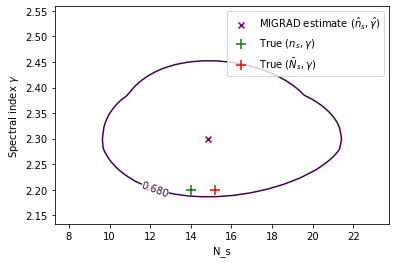

In [23]:
m.draw_mncontour('n_s','gamma')
plt.scatter(mn_h, mg_h, marker='x', c='purple', label=r'MIGRAD estimate $(\hat{n}_s,\hat{\gamma})$')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], s=100, marker='+', c='g', label='True $(n_s,\gamma)$')
plt.scatter(sim.Nex_ps, sim.truth['gamma'],s=100 , marker='+', c='r', label = r'True $(\bar{N}_s,\gamma)$')
plt.legend()

# Make less tight
xlim = plt.xlim()
ylim = plt.ylim()
axrange = (xlim[1]-xlim[0], ylim[1]-ylim[0])
plt.xlim(xlim[0]-axrange[0]*.2, xlim[1]+axrange[0]*.2)
plt.ylim(ylim[0]-axrange[1]*.2, ylim[1]+axrange[1]*.4)

plt.xlabel('N_s')
plt.ylabel('Spectral index $\gamma$')

plt.show()

# BHM

In [24]:
from nu_stats.bhmutils import BhStructure

In [25]:
bhm = BhStructure(fit_input)
bhm.load_model("stan/toy_bhm.stan")

INFO:cmdstanpy:found newer exe file, not recompiling
INFO:cmdstanpy:compiled model file: /home/vmu/nu_stats/examples/bayes_hierarchical_model/stan/toy_bhm


In [26]:
bhm.run(seed=1)

INFO:cmdstanpy:start chain 1
INFO:cmdstanpy:start chain 2
INFO:cmdstanpy:start chain 3
INFO:cmdstanpy:start chain 4
INFO:cmdstanpy:finish chain 2
INFO:cmdstanpy:finish chain 3
INFO:cmdstanpy:finish chain 1
INFO:cmdstanpy:finish chain 4


In [27]:
bhm.vars.keys()

dict_keys(['gamma', 'L', 'F_bg', 'Etrue', 'f', 'F_src', 'F', 'Nex', 'Nex_ps', 'Nex_bg', 'log_prob', 'Earr'])

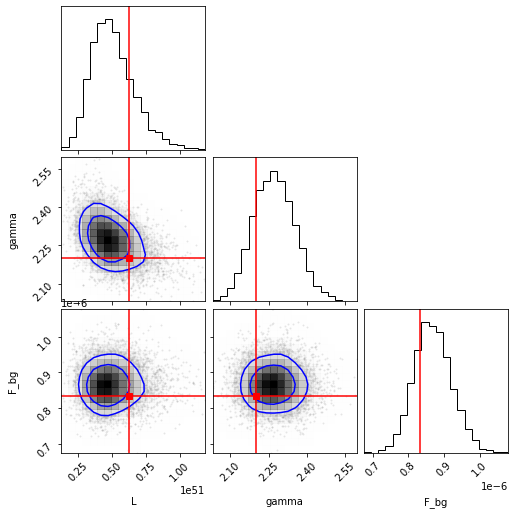

In [28]:
vnames = ['L','gamma','F_bg']
bhm.plot_corner(vnames, [sim.truth[nam] for nam in vnames], truth_color='r',
smooth=True, levels=(.393,.68,), contour_kwargs={'colors':'b'})
plt.show()

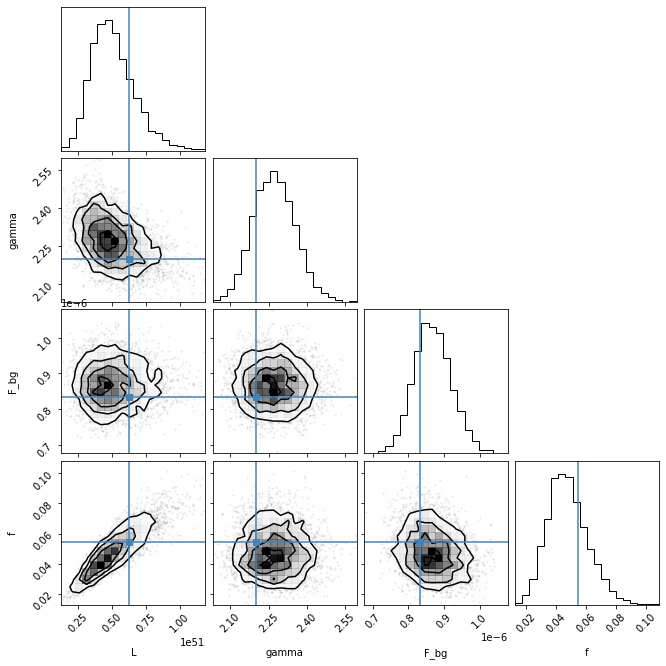

In [29]:
# Corner plot, comparing with truth from sim
var_names = list(sim.truth.keys())
truths_list = [sim.truth[key] for key in var_names]
bhm.plot_corner(var_names, truths_list)

In [30]:
bhm.print_summary()

                   Mean          MCSE        StdDev            5%  \
name                                                                
lp__      -9.100000e+03  4.300000e-01  1.400000e+01 -9.100000e+03   
gamma      2.300000e+00  1.500000e-03  8.200000e-02  2.100000e+00   
L          5.100000e+50  2.600000e+48  1.600000e+50  2.800000e+50   
F_bg       8.700000e-07  7.700000e-10  5.300000e-08  7.800000e-07   
Etrue[1]   3.052970e+05  2.111000e+03  1.570880e+05  1.270780e+05   
...                 ...           ...           ...           ...   
Earr[284]  1.706990e+05  1.202000e+03  8.934500e+04  6.780800e+04   
Earr[285]  1.145050e+05  7.830000e+02  5.664000e+04  5.518200e+04   
Earr[286]  1.054230e+05  6.320000e+02  4.861800e+04  5.440400e+04   
Earr[287]  1.009950e+05  6.210000e+02  4.614900e+04  5.349200e+04   
Earr[288]  5.355920e+05  4.206000e+03  2.825350e+05  2.175320e+05   

                    50%           95%   N_Eff  N_Eff/s  R_hat  
name                                  

In [31]:
bhm.print_diagnostic()

INFO:cmdstanpy:Processing csv files: /tmp/tmpqe62t8jt/toy_bhm-202104151802-1-f7lp3q6o.csv, /tmp/tmpqe62t8jt/toy_bhm-202104151802-2-nnbr9oz5.csv, /tmp/tmpqe62t8jt/toy_bhm-202104151802-3-1n1kgwb0.csv, /tmp/tmpqe62t8jt/toy_bhm-202104151802-4-o_79p6p9.csv

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory for all transitions.

Effective sample size satisfactory.

Split R-hat values satisfactory all parameters.

Processing complete, no problems detected.


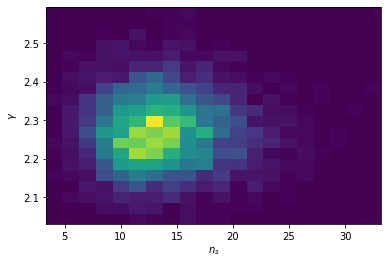

In [32]:
plt.hist2d(bhm.fit.stan_variable('Nex_ps'),bhm.fit.stan_variable('gamma'), bins=20)
plt.xlabel('$n_s$')
plt.ylabel('$\gamma$')
plt.show()

### It might be interesting to see the ACF for the chains as well

In [33]:
from statsmodels.graphics.tsaplots import plot_acf

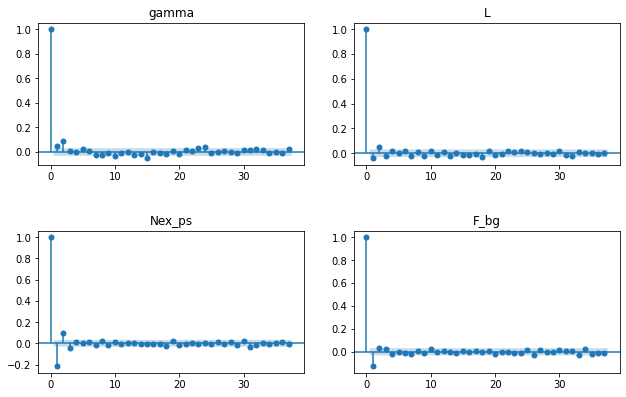

In [34]:
fig, ax = plt.subplots(2,2)
for i, vname in enumerate(['gamma','F_bg','L','Nex_ps']):
    plot_acf(bhm.fit.stan_variable(vname),ax=ax[i%2,i//2-i%2])
    ax[i%2,i//2-i%2].set_title(vname)
plt.tight_layout()
fig.set_size_inches(*(fig.get_size_inches()*1.5))
fig.show()

# HDI

In [35]:
import arviz as az
import seaborn as sns


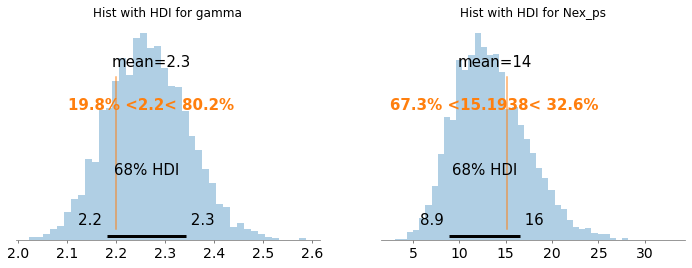

In [36]:
fig, ax = plt.subplots(1,2)
az.plot_posterior(bhm.fit.stan_variable('gamma'),
    hdi_prob=.68,
    ref_val = sim.truth['gamma'],
    kind='hist',
    ax = ax[0]
)
ax[0].set_title('Hist with HDI for gamma')
az.plot_posterior(bhm.fit.stan_variable('Nex_ps'),
    hdi_prob=.68,
    ref_val = sim.Nex_ps,
    kind = 'hist',
    ax = ax[1]
)
ax[1].set_title('Hist with HDI for Nex_ps')
fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()

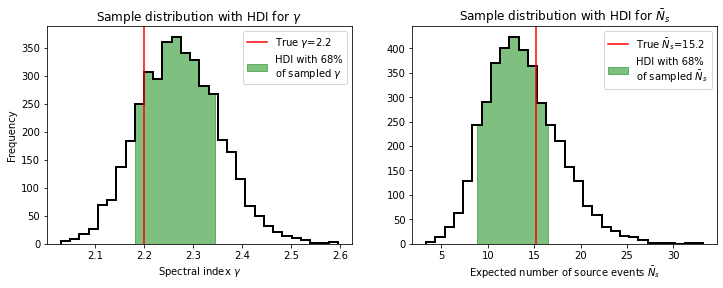

In [37]:
g_hdi = az.hdi(bhm.fit.stan_variable('gamma'), hdi_prob=.68)
ns_hdi = az.hdi(bhm.fit.stan_variable('Nex_ps'), hdi_prob=.68)

fig, ax = plt.subplots(1,2)
_,_,patches = ax[0].hist(bhm.fit.stan_variable('gamma'),
    bins=30,
    histtype = 'step',
    linewidth = 2,
    color = 'k'
)
ax[0].axvline(sim.truth['gamma'],
    label=r'True $\gamma$'+f'={sim.gamma:.3}',
    c='r'
)
ax[0].axvspan(*g_hdi, label=r'HDI with 68%'+'\n'+r'of sampled $\gamma$',
    clip_path=patches[0],
    alpha =.5,
    color='g'
)
ax[0].set_title('Sample distribution with HDI for $\gamma$')
ax[0].legend()
ax[0].set_xlabel('Spectral index $\gamma$')
ax[0].set_ylabel('Frequency')

_,_,patches = ax[1].hist(bhm.fit.stan_variable('Nex_ps'),
    bins=30,
    histtype = 'step',
    linewidth = 2,
    color = 'k'
)
ax[1].axvline(sim.Nex_ps,
    label=r'True $\bar{N}_s$'+f'={sim.Nex_ps:.3}',
    c='r'
)
ax[1].axvspan(*ns_hdi, label=r'HDI with 68%'+'\n'+r'of sampled $\bar{N}_s$',
    clip_path=patches[0],
    alpha =.5,
    color ='g',
)
ax[1].set_title(r'Sample distribution with HDI for $\bar{N}_s$')
ax[1].legend()
ax[1].set_xlabel(r'Expected number of source events $\bar{N}_s$')

fig.set_size_inches((fig.get_size_inches()[0]*2,fig.get_size_inches()[1]))
fig.show()

# HDR?

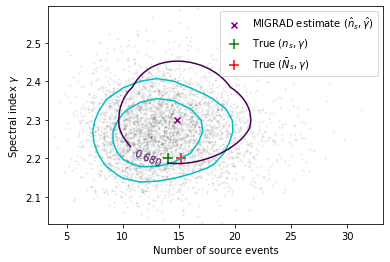

In [38]:
corner.hist2d(bhm.fit.stan_variable('Nex_ps'),
    bhm.fit.stan_variable('gamma'),
    smooth=True,
    levels=(.39,.68),
    plot_density = False,
    #data_kwargs = {'label':'Stan chain samples'},
    no_fill_contours = True,
    contour_kwargs={'colors':'c', 'alpha':1}
)
m.draw_mncontour('n_s', 'gamma')
plt.scatter(mn_h, mg_h, marker='x', c='purple', label=r'MIGRAD estimate $(\hat{n}_s,\hat{\gamma})$')
plt.scatter(sum(sim.labels==0),sim.truth['gamma'], s=100, marker='+', c='g', label='True $(n_s,\gamma)$')
plt.scatter(sim.Nex_ps, sim.truth['gamma'],s=100 , marker='+', c='r', label = r'True $(\bar{N}_s,\gamma)$')
plt.legend()
plt.ylabel(r'Spectral index $\gamma$')
plt.xlabel(r'Number of source events')
plt.show()